In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

# Data Preparation

In [118]:
yield_df = pd.read_csv('./data/yield_df.csv')
yield_df.drop('Unnamed: 0', axis=1, inplace=True)
yield_df.head()

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


In [119]:
yield_df.describe()

,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
count,28242.000000,28242.000000,28242.00000,28242.000000,28242.000000
mean,2001.544296,77053.332094,1149.05598,37076.909344,20.542627
std,7.051905,84956.612897,709.81215,59958.784665,6.312051
min,1990.000000,50.000000,51.00000,0.040000,1.300000
25%,1995.000000,19919.250000,593.00000,1702.000000,16.702500
50%,2001.000000,38295.000000,1083.00000,17529.440000,21.510000
75%,2008.000000,104676.750000,1668.00000,48687.880000,26.000000
max,2013.000000,501412.000000,3240.00000,367778.000000,30.650000


## Check for Null Value

In [120]:
yield_df.isnull().sum()

Area                             0
Item                             0
Year                             0
hg/ha_yield                      0
average_rain_fall_mm_per_year    0
pesticides_tonnes                0
avg_temp                         0
dtype: int64

## Duplicate Detection

In [121]:
yield_df.duplicated(keep='last').sum()

2310

In [122]:
yield_no_duplicate = yield_df.drop_duplicates(keep='last')

In [123]:
yield_df.shape[0], yield_no_duplicate.shape[0]

(28242, 25932)

## Outliers Detection

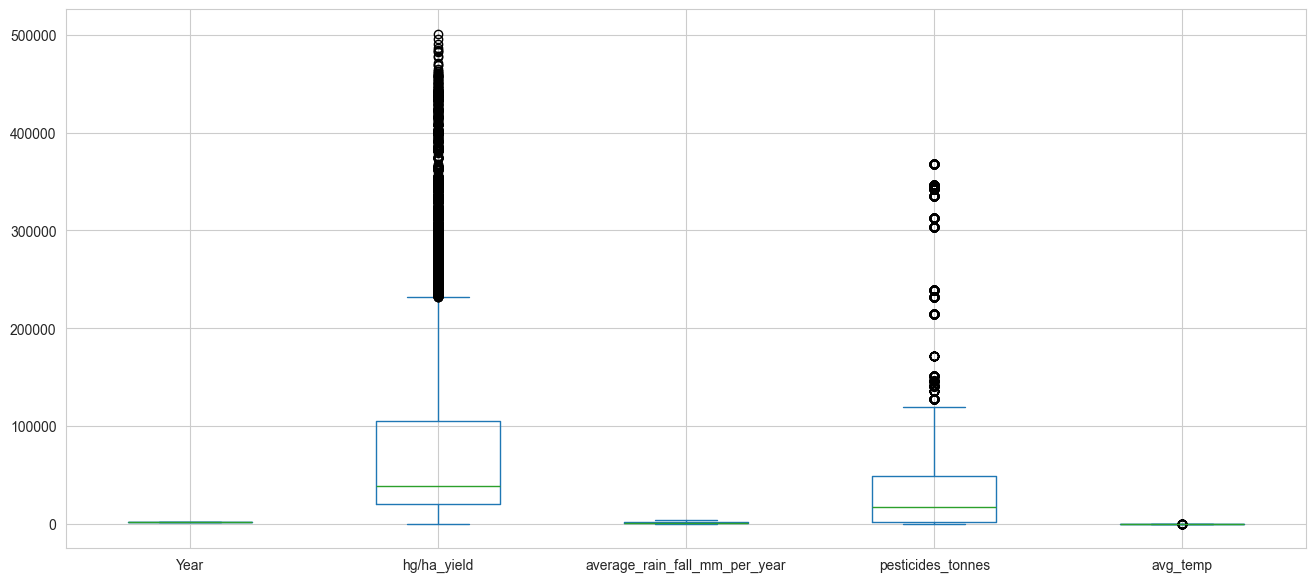

In [124]:
yield_df.plot(kind='box', figsize=(16, 7))
plt.show()

## Log Transformation

In [125]:
def log_transform(df):
    data = df.copy()
    data['ha_yield_log'] = np.log(df['hg/ha_yield'] + df['hg/ha_yield'].min())
    data['pesticides_tonnes_log'] = np.log(df['pesticides_tonnes'] + 1)
    data.drop(['pesticides_tonnes', 'hg/ha_yield'], axis=1, inplace=True)
    return data

In [126]:
log_yield = log_transform(yield_no_duplicate)

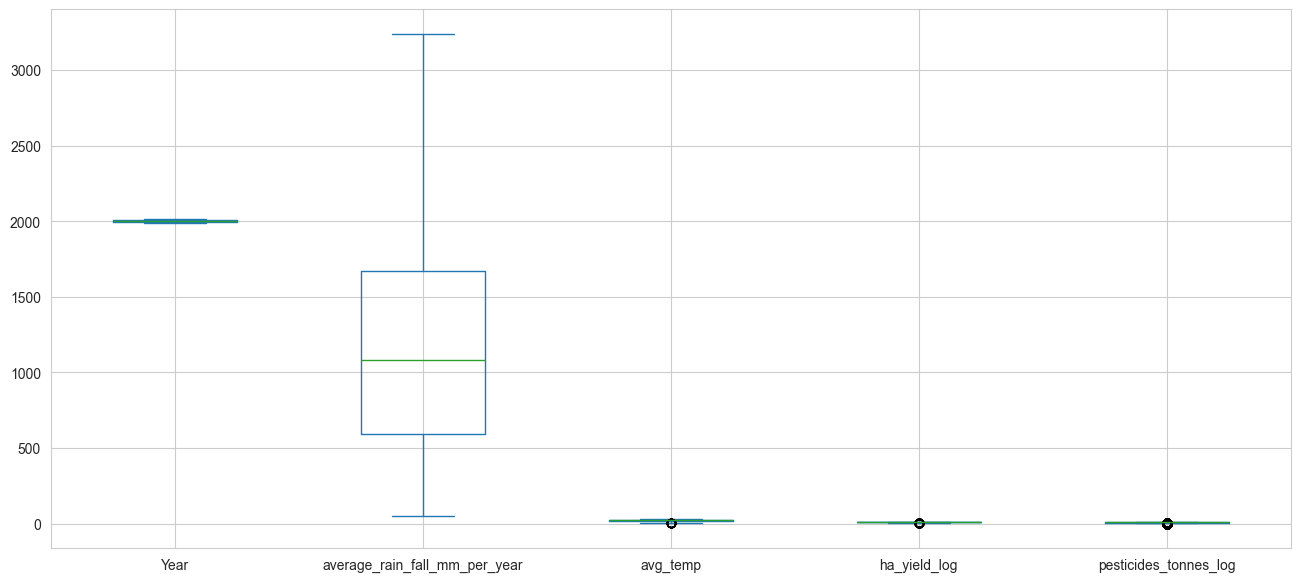

In [127]:
log_yield.plot(kind='box', figsize=(16, 7))
plt.show()

## Data Encoding

In [128]:
ordinal_cols = ['Area', 'Item']
num_col = log_yield.select_dtypes(include=np.number).columns.tolist()

In [143]:
X = log_yield.drop('ha_yield_log', axis=1)
y = log_yield['ha_yield_log']

In [145]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

transformer = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(), ordinal_cols),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
).set_output(transform="pandas")

X_transformed = transformer.fit_transform(X)

In [146]:
X_transformed.head()

,Area,Item,Year,average_rain_fall_mm_per_year,avg_temp,pesticides_tonnes_log
0,0.0,1.0,1990,1485.0,16.37,4.804021
1,0.0,3.0,1990,1485.0,16.37,4.804021
2,0.0,4.0,1990,1485.0,16.37,4.804021
3,0.0,5.0,1990,1485.0,16.37,4.804021
4,0.0,6.0,1990,1485.0,16.37,4.804021


# Model Training

## Data splitting

In [147]:
from sklearn.model_selection import train_test_split

In [148]:
X_train, X_hold_out, y_train, y_hold_out = train_test_split(X_transformed, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_hold_out, y_hold_out, test_size=0.5, random_state=42)

In [149]:
len(X_train), len(X_hold_out), len(X_test), len(X_val)

(18152, 7780, 3890, 3890)

## Model Comparison

In [150]:
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [156]:
X_train.columns

Index(['Area', 'Item', 'Year', 'average_rain_fall_mm_per_year', 'avg_temp',
       'pesticides_tonnes_log'],
      dtype='object')

In [151]:
## Model Training and Evaluation
models = {
    "Linear Regression": LinearRegression(),
    "KNN": KNeighborsRegressor(),
    "Support Vector Machine": SVR(),
    "Random Forest": RandomForestRegressor(n_estimators=22, random_state=42, max_depth=8),
    "XGBoost": XGBRegressor(n_estimators=22, random_state=42, max_depth=8)
}

results = {}

# Train and evaluate each model
for name, model in models.items():
    # Train on training set
    model.fit(X_train, y_train)
    
    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_rmse = root_mean_squared_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)

    results[name] = {
        "Validation MSE": val_mse,
        "Validation RMSE": val_rmse,
        "Validation R2": val_r2,
    }

results_df = pd.DataFrame(results).T
print("Model Performance Comparison:")
print(results_df)

Model Performance Comparison:
                        Validation MSE  Validation RMSE  Validation R2
Linear Regression             1.112352         1.054681       0.118873
KNN                           0.554934         0.744939       0.560420
Support Vector Machine        1.253142         1.119438       0.007349
Random Forest                 0.113872         0.337449       0.909799
XGBoost                       0.046107         0.214726       0.963477


## Fine Tune best Model

In [152]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [i for i in range(2,30,4)],
    'max_depth': [j for j in range(5,10)],
}

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid=param_grid,
    cv=3,                
    n_jobs=-1,           
    verbose=2,
    scoring='neg_mean_squared_error' 
)

# Fit on your training data
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Best model
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 35 candidates, totalling 105 fits
Best Parameters: {'max_depth': 9, 'n_estimators': 26}


## Fine Tuned Model Evaluation

In [153]:
# Predict on the validation set
y_val_pred = best_model.predict(X_val)

# MSE, RMSE, R2
mse = mean_squared_error(y_val, y_val_pred)
rmse = root_mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print("Validation MSE:", mse)
print("Validation RMSE:", rmse)
print("Validation R2:", r2)

Validation MSE: 0.036326695353960096
Validation RMSE: 0.19059563309257666
Validation R2: 0.9712245418703962


In [154]:
y_test_pred = best_model.predict(X_test)

# MSE, RMSE, R2
mse = mean_squared_error(y_test, y_test_pred)
rmse = root_mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R2:", r2)

Test MSE: 0.033991250433219475
Test RMSE: 0.18436716202518136
Test R2: 0.9719077099006136


## Save Model

In [161]:
import pickle 

filename = ['pipeline-final.sav', 'xgboost_model-final.sav']
pickle.dump(transformer, open(filename[0], 'wb')) 
pickle.dump(best_model, open(filename[1], 'wb')) 